In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb


In [42]:
df = pd.read_csv('dataCarSale2021-2025.csv')

df['waktu'] = pd.to_datetime(df['waktu'])
df = df.set_index('waktu')

df.info()
print(df.describe())
print(df.head(60))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54 entries, 2021-01-01 to 2025-07-01
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DAIHATSU    54 non-null     float64
 1   HONDA       54 non-null     float64
 2   MITSUBISHI  54 non-null     float64
 3   SUZUKI      54 non-null     float64
 4   TOYOTA      54 non-null     float64
dtypes: float64(5)
memory usage: 2.5 KB
           DAIHATSU         HONDA    MITSUBISHI        SUZUKI        TOYOTA
count     54.000000     54.000000     54.000000     54.000000     54.000000
mean   11254.531630   7645.139556   8760.141000   5609.579630  19934.127907
std     4597.871605   3886.261244   3351.676613   2351.526395   7855.556087
min     5755.232000   1590.411000   4349.666000   2004.813000   7617.122000
25%     7477.087250   3855.075250   6204.000000   3227.915000  12472.187250
50%     9310.389000   7725.500000   7637.046000   5830.500000  20983.500000
75%    15638.000000

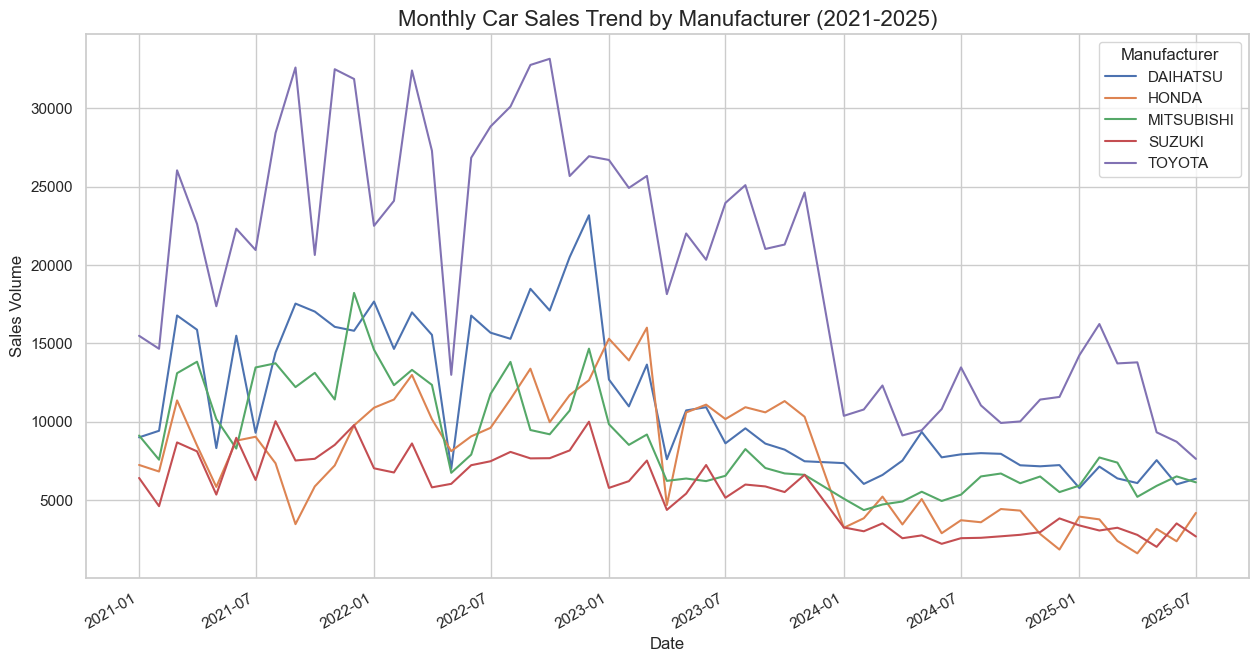

In [43]:
df.plot(figsize=(15, 8), linestyle='-')
plt.title('Monthly Car Sales Trend by Manufacturer (2021-2025)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales Volume', fontsize=12)
plt.legend(title='Manufacturer')
plt.grid(True)
plt.show()

In [ ]:
# Calculate total sales to use as the target variable
df['TOTAL_SALES'] = df.sum(axis=1)

def create_features(df):
    """Function to create time-series features from a datetime index."""
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week.astype(int)
    return df

df = create_features(df)

# Define features and the target
FEATURES = ['year', 'month', 'quarter', 'dayofyear', 'weekofyear']
TARGET = ['DAIHATSU', 'HONDA', 'MITSUBISHI', 'SUZUKI', 'TOYOTA']

X = df[FEATURES]
y = df[TARGET]

# print("■ Features Created:")
# print(X.head(20))
# print("■ Target Created:")
# print(y.head(20))

print(df.head(20))


            DAIHATSU    HONDA  MITSUBISHI   SUZUKI   TOYOTA  TOTAL_SALES  \
waktu                                                                      
2021-01-01    8993.0   7231.0      9108.0   6400.0  15474.0      47206.0   
2021-02-01    9412.0   6812.0      7567.0   4600.0  14645.0      43036.0   
2021-03-01   16770.0  11350.0     13088.0   8669.0  26034.0      75911.0   
2021-04-01   15861.0   8474.0     13820.0   8100.0  22618.0      68873.0   
2021-05-01    8310.0   5832.0     10160.0   5341.0  17361.0      47004.0   
2021-06-01   15481.0   8782.0      8277.0   8965.0  22310.0      63815.0   
2021-07-01    9284.0   9030.0     13453.0   6274.0  20950.0      58991.0   
2021-08-01   14408.0   7337.0     13720.0  10021.0  28418.0      73904.0   
2021-09-01   17529.0   3453.0     12200.0   7515.0  32596.0      73293.0   
2021-10-01   17020.0   5861.0     13109.0   7624.0  20633.0      64247.0   
2021-11-01   16045.0   7201.0     11410.0   8512.0  32487.0      75655.0   
2021-12-01  

In [45]:
# Use data before 2025 for training, and data from 2025 for validation
TRAIN_END = '2024-12-31'
X_train, y_train = X.loc[X.index <= TRAIN_END], y.loc[y.index <= TRAIN_END]
X_val, y_val = X.loc[X.index > TRAIN_END], y.loc[y.index > TRAIN_END]

print(f"Training data period: {X_train.index.min()} to {X_train.index.max()}")
print(f"Validation data period: {X_val.index.min()} to {X_val.index.max()}")

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=3,
    random_state=42,
    early_stopping_rounds=50 # Added for efficiency
)

# Train the model on the training data
# Note: XGBoost uses eval_set for early stopping
print("Training XGBoost model...")
model.fit(X_train, y_train,
          eval_set=[(X_val, y_val)],
          verbose=False) # <-- This is the crucial training step


Training data period: 2021-01-01 00:00:00 to 2024-12-01 00:00:00
Validation data period: 2025-01-01 00:00:00 to 2025-07-01 00:00:00
Training XGBoost model...


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

SMAPE Score on Validation Data: 20.9570

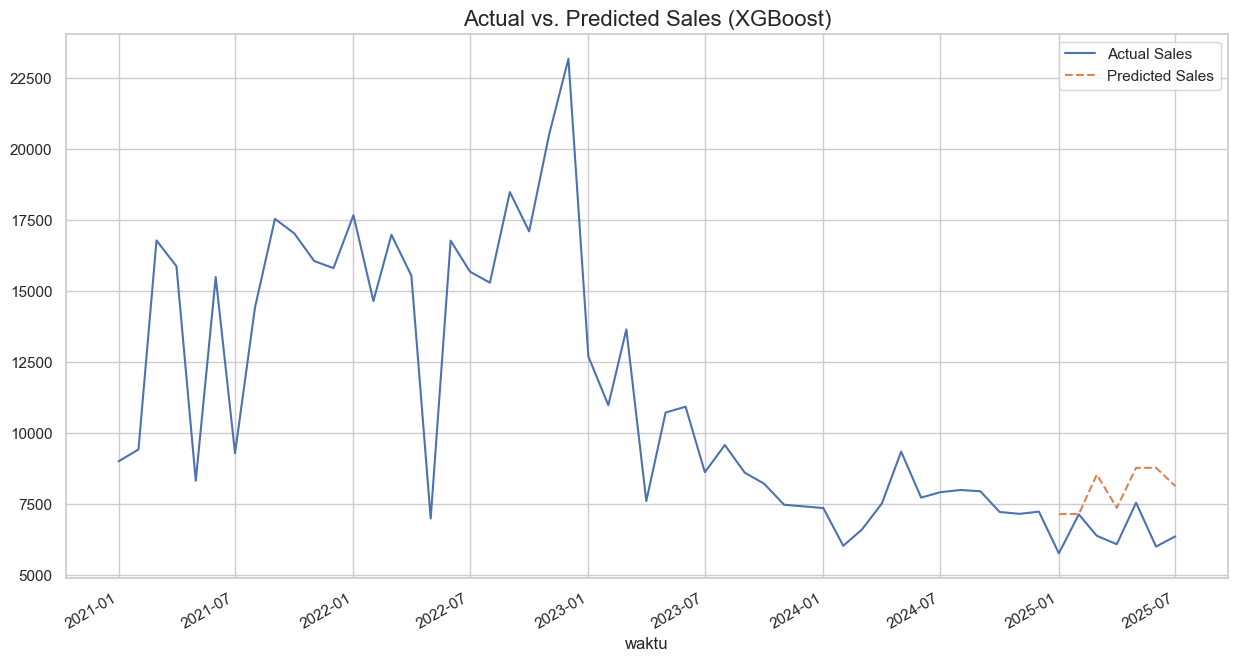


Predicted Total Sales for August 1, 2025: 8,123 units


In [46]:
# Define the SMAPE function
def smape(y_true, y_pred):
    """Function to calculate SMAPE"""
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    # Avoid division by zero
    denominator[denominator == 0] = 1e-9
    return np.mean(numerator / denominator) * 100

# Predict on the validation set
val_preds = model.predict(X_val)

# Calculate the SMAPE score
smape_score = smape(y_val, val_preds)
print(f'SMAPE Score on Validation Data: {smape_score:.4f}')

# Visualize the prediction results
results = pd.DataFrame({'Actual': y_val, 'Predicted': val_preds}, index=y_val.index)

df[TARGET].plot(figsize=(15, 8), legend=True, label='Actual Sales')
results['Predicted'].plot(legend=True, label='Predicted Sales', style='--')
plt.title('Actual vs. Predicted Sales (XGBoost)', fontsize=16)
plt.show()

# --- Predict the future date ---
future_date = pd.to_datetime('2025-08-01')
future_df = pd.DataFrame(index=[future_date])
# Assuming create_features function is defined from previous cells
future_df = create_features(future_df)
X_future = future_df[FEATURES]
prediction = model.predict(X_future)
print(f"\nPredicted Total Sales for August 1, 2025: {prediction[0]:,.0f} units")